## <font color='white'> __1. Pre Information__ </font> <a class="anchor" id="one"></a>

[<font color='mediumpurple'>Back to Index </font>](#index)


#### <font color='white'> __1.1 Libraries__ </font> <a class="anchor" id="oneone"></a>

[<font color='mediumpurple'>Back to Index </font>](#index)


In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import MetaTrader5 as mt5
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.signal import find_peaks
from datetime import time, datetime, timezone

#### <font color='white'> __1.2 Metatrader Info__ </font> <a class="anchor" id="onetwo"></a>

[<font color='mediumpurple'>Back to Index </font>](#index)

In [2]:
# Start the plataform with initialize()
mt5.initialize()

# User credentials
login = 51116412
password = '39sz2vL3'
server = 'ICMarketsSC-Demo'

# log in in the server account of MT5
mt5.login(login, password, server)

True

In [3]:
# Set the ticker
ticker = 'EURUSD'

In [4]:
# If Cambial
data = pd.DataFrame(mt5.copy_rates_from_pos(ticker, mt5.TIMEFRAME_D1, 0, 10000))[['time', 'open', 'high', 'low', 'close','tick_volume']]
data.rename(columns={'tick_volume': 'volume'}, inplace=True)

def convert_timestamp_to_datetime(timestamp):
    dt_object = datetime.fromtimestamp(timestamp, tz=timezone.utc)
    return dt_object.strftime("%Y-%m-%d %H:%M:%S %Z")

# Apply the function to the 'time' column
data['time'] = data['time'].apply(convert_timestamp_to_datetime)
data['time'] = pd.to_datetime(data['time'])
#  data.set_index('time', inplace=True)

#### <font color='white'> __3.11 Fixed Range Volume Profile (FRVP)__</font> <a class="anchor" id="threeeleven"></a>

[<font color='mediumpurple'>Back to Index </font>](#index)

https://medium.com/swlh/how-to-analyze-volume-profiles-with-python-3166bb10ff24

* Once this metric is made to run on daily and weekly basis in order to combine both trend, p.e. 4th day of the week, 4 frvp's combining a trend crossover with the weekly trend in order to reinforce the confirmation or not.   


In [5]:
# Daily 
kde_factor = .01 #.02
step = 500
kde = stats.gaussian_kde(data.close, weights=data.volume, bw_method=kde_factor)
xr = np.linspace(data.close.min(), data.close.max(),step)
kdy = kde(xr)

# Find Peaks of the distribution
peaks, _ = find_peaks(kdy, prominence=1)

close_avg_peak = xr[peaks]
volume_pd_peak = kdy[peaks]

peak_df = pd.DataFrame({'close_avg': close_avg_peak, 'volume_prob_d': volume_pd_peak})

peak_df

,close_avg,volume_prob_d
0,1.073648,3.926574
1,1.086799,5.742098
2,1.101829,5.121728
3,1.120617,7.388156
4,1.178858,5.056725
5,1.229585,2.908867
6,1.293463,2.377508
7,1.359219,2.116353


In [12]:
def get_volume_profile(data):

        '''
        Fundamentals:

        * This function measure the probability density of a event fall into the corresponding bin getting peaks and vallyes of the gaussian funtion. 
        * Is used as measure of frequency of price reached which is result of *probability density*, 
        the area of each bar corresponds to the probability that an event will fall into the corresponding bin (here, the sum of all bin AREAS equals 1).
        Once histogram can lead to a perfect and accurate detection of peaks and vallyes due bins is applied kernel density estimation.
        * Kernel density estimation is a way to estimate the probability density function (PDF) of a random variable in a non-parametric way. 
        gaussian_kde works for both uni-variate and multi-variate data.
        * The strategy is to act in High Volume Nodes, "where the volume is high is where the price moves out" 
        
        Conditions:

        __kde_factor__ : [0;1], the highest he value the smooth the line of p.density of volume and less peaks and valleys are detected. 
        Is used a default of 0.02 for daily analizes and 0.04 for weekly analizes, this values are choosed by testing several values until get the most relaible.   
        https://aakinshin.net/posts/kde-bw/
        '''

        current_close_value = data.tail(1).close.iloc[0]
        
        # Daily 
        kde_factor = .01 #.02
        step = 500
        kde = stats.gaussian_kde(data.close, weights=data.volume, bw_method=kde_factor)
        xr = np.linspace(data.close.min(), data.close.max(),step)
        kdy = kde(xr)

        # Find Peaks of the distribution
        peaks, _ = find_peaks(kdy, prominence=1)

        close_avg_peak = xr[peaks]
        volume_pd_peak = kdy[peaks]
        
        peak_df = pd.DataFrame({'close_avg': close_avg_peak, 'volume_prob_d': volume_pd_peak})


        peak_df = peak_df.sort_values(by='close_avg', ascending=True)
        peak_df.reset_index(inplace=True, drop=True)

        peak_df['peakvall_order'] = peak_df['close_avg'].rank(method='first')
        peak_df['poc_order'] = peak_df['volume_prob_d'].rank(method='first', ascending=False)


        # VIZUALIZATION
        # FRVP daily chart
        fig = go.Figure()
        fig.add_trace(go.Histogram(name='Vol Profile',
                                x=data.close,  ## Ver porque é que não se usa resultados em vez dos dados
                                y=data.volume, 
                                nbinsx=step, 
                                histfunc='sum', 
                                histnorm='probability density', #'density', #'percent', #'probability', #'probability density',
                                marker_color='#B0C4DE'))
                        
        fig.add_trace(go.Scatter(name='KDE',
                                x=xr, 
                                y=kdy, 
                                mode='lines', 
                                marker_color='#D2691E'))

        fig.add_trace(go.Scatter(name="Peaks", x=close_avg_peak, y=volume_pd_peak, 
                                mode='markers', 
                                marker=dict(size=10, color="MediumPurple")))

        fig.add_trace(go.Scatter(name="Poc", 
                                x=peak_df[peak_df['poc_order'] == 1].close_avg, 
                                y=peak_df[peak_df['poc_order'] == 1].volume_prob_d, 
                                mode='markers',
                                text=[peak_df[peak_df['poc_order'] == 1].poc_order],
                                marker=dict(color='LightSkyBlue',
                                                size=10,
                                                line=dict(color='blue',
                                                        width=1)))
        )

        fig.update_layout(
                title=dict(text='Fixed Range Volume Profile (Daily over 2 Months)', x=0.5),
                xaxis_title="Average of Close",
                yaxis_title="Probability Density of Volume",
                xaxis=dict(zeroline=False, showgrid=False), 
                yaxis=dict(zeroline=False, showgrid=False)
                )

        fig.add_vrect(name="Current Close Price",
                        x0=current_close_value,
                        x1=current_close_value,
                        fillcolor='orange',
                        opacity=1,
                        line_width=1
                        )
        
        # fig.add_vrect(name="Support Line",
        #                 x0=support,
        #                 x1=support,
        #                 fillcolor='orange',
        #                 opacity=1,
        #                 line_width=3
        #                 )
        
        # fig.add_vrect(name="Resistence Line",
        #                 x0=resistence,
        #                 x1=resistence,
        #                 fillcolor='orange',
        #                 opacity=1,
        #                 line_width=3
        #                 )
        
        fig.show()

        return peak_df

get_volume_profile(data)

,close_avg,volume_prob_d,peakvall_order,poc_order
0,1.073648,3.926574,1.0,5.0
1,1.086799,5.742098,2.0,2.0
2,1.101829,5.121728,3.0,3.0
3,1.120617,7.388156,4.0,1.0
4,1.178858,5.056725,5.0,4.0
5,1.229585,2.908867,6.0,6.0
6,1.293463,2.377508,7.0,7.0
7,1.359219,2.116353,8.0,8.0


In [7]:
data1 = data.tail(100)
peaks_df = get_volume_profile(data1)

In [8]:

fig = go.Figure(go.Scatter(x=data1.time, y=data1.close, line=dict(color='blue', width=1), name="Data"))

for i in peaks_df.close_avg:
    fig.add_trace(go.Scatter(x=data1.time, y=[i] * len(data1.index), line=dict(color='red', width=1), name="OVERBOUGHT_LEVEL"))

# Add a title to the plot
fig.update_layout(title=dict(text=f'Resistences and Supports on {ticker} in Daily Timeframe', x=.5),
                xaxis_rangeslider_visible=False)

fig.show()

c:\Users\joaom\AppData\Local\Programs\Python\Python311\Lib\site-packages\_plotly_utils\basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Text(0.5, 1.0, 'Simple Scatter Plot')

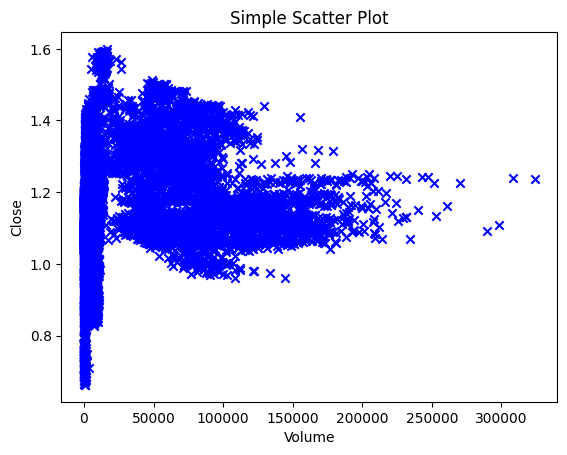

In [13]:
plt.scatter(x=data.volume,
            y=data.close,
            label='Data Points',
            color='blue',
            marker='x',
            linestyle='-')

# Add labels and a title
plt.xlabel('Volume')
plt.ylabel('Close')
plt.title('Simple Scatter Plot')

c:\Users\joaom\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



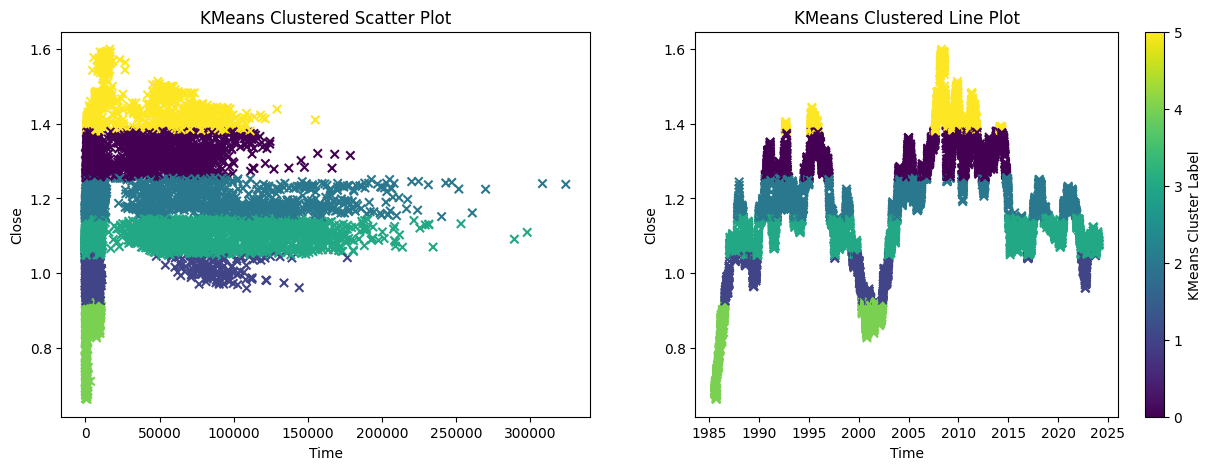

In [14]:
from sklearn.cluster import KMeans

X = data[['close']].values

# Define the number of clusters (you can adjust this)
n_clusters = 6

# Apply K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data['cluster_kmeans'] = kmeans.fit_predict(X)

plt.figure(figsize=(15, 5))
# Plot the clustered data Scatted
plt.subplot(1, 2, 1)
plt.scatter(data['volume'], data['close'], c=data['cluster_kmeans'], cmap='viridis', marker='x')
plt.xlabel('Time')
plt.ylabel('Close')
plt.title('KMeans Clustered Scatter Plot')

# Plot the clustered data Lined
plt.subplot(1, 2, 2)
plt.scatter(data['time'], data['close'], c=data['cluster_kmeans'], cmap='viridis', marker='x')
plt.xlabel('Time')
plt.ylabel('Close')
plt.title('KMeans Clustered Line Plot')

# Add colorbar for cluster labels
cbar = plt.colorbar()
cbar.set_label('KMeans Cluster Label')

plt.show()

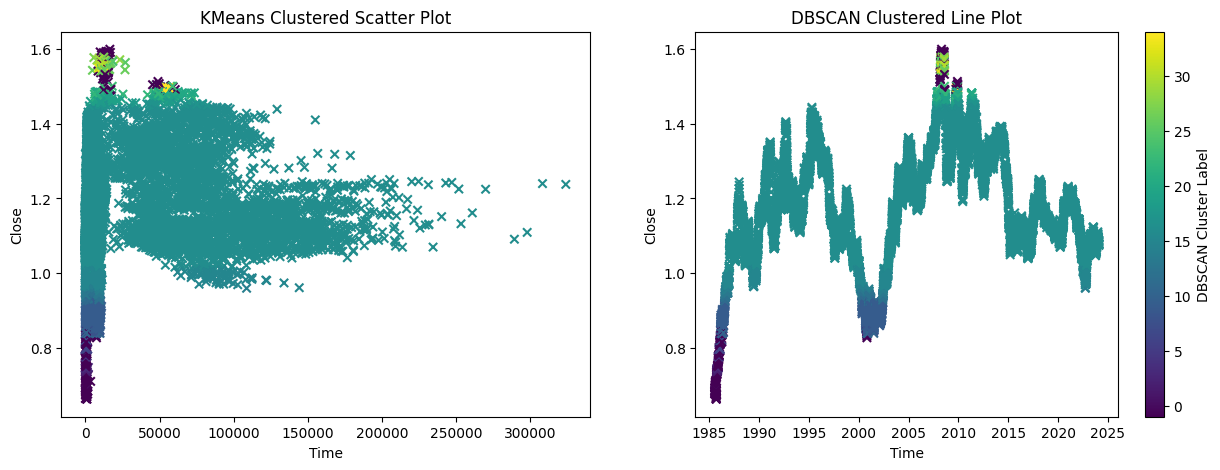

In [15]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.001,
                min_samples=5)

data['cluster_dbscan'] = dbscan.fit_predict(X)

plt.figure(figsize=(15, 5))
# Plot the clustered data Scatted
plt.subplot(1, 2, 1)
plt.scatter(data['volume'], data['close'], c=data['cluster_dbscan'], cmap='viridis', marker='x')
plt.xlabel('Time')
plt.ylabel('Close')
plt.title('KMeans Clustered Scatter Plot')

# Plot the clustered data Lined
plt.subplot(1, 2, 2)
plt.scatter(data['time'], data['close'], c=data['cluster_dbscan'], cmap='viridis', marker='x')
plt.xlabel('Time')
plt.ylabel('Close')
plt.title('DBSCAN Clustered Line Plot')

# Add colorbar for cluster labels
cbar = plt.colorbar()
cbar.set_label('DBSCAN Cluster Label')

plt.show()

Continuar pagina 283 KEras Scikit_learn 